<a href="https://colab.research.google.com/github/rohinish404/learning_pytorch/blob/master/pytorch_classification_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles
n_samples = 1000
X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

In [3]:
len(X)

1000

In [4]:
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [5]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [6]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label":y})

In [7]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


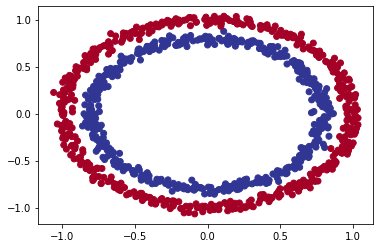

In [8]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y= X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [9]:
import torch 
torch.__version__

'1.13.1+cu116'

In [10]:
type(X)

numpy.ndarray

In [11]:
X = torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [12]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [14]:
len(X_train)

800

In [15]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
from sklearn import datasets

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2,out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5,out_features = 1)


  def forward(self,x):
    return self.layer_2(self.layer_1(x)) 


model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
device

'cuda'

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.2171, -0.6518],
                      [-0.3556,  0.2261],
                      [-0.2898, -0.4891],
                      [-0.1389,  0.0019],
                      [-0.5627, -0.1887]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6955,  0.1269, -0.3099, -0.2143,  0.2020], device='cuda:0')),
             ('1.weight',
              tensor([[ 8.0075e-05,  4.1603e-01,  1.8928e-01,  4.3179e-01, -1.8241e-01]],
                     device='cuda:0')),
             ('1.bias', tensor([0.2073], device='cuda:0'))])

In [20]:
untrained_preds = model_0(X_test.to(device))

In [21]:
len(untrained_preds)

200

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [23]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


In [24]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits  

tensor([[ 0.1571],
        [ 0.1048],
        [ 0.1730],
        [ 0.1532],
        [-0.0197]], device='cuda:0')

In [25]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5392],
        [0.5262],
        [0.5431],
        [0.5382],
        [0.4951]], device='cuda:0')

In [26]:
y_preds = torch.round(y_preds_probs)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train.to(device)).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))


    test_loss =  loss_fn(test_logits,y_test)
    test_acc =  accuracy_fn(y_true = y_test,
                    y_pred = test_pred)
    

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")    

Epoch: 0 | Loss: 0.69536, Accuracy: 51.00% | Test loss: 0.69414, Test acc: 55.50%
Epoch: 10 | Loss: 0.69465, Accuracy: 50.00% | Test loss: 0.69368, Test acc: 56.50%
Epoch: 20 | Loss: 0.69425, Accuracy: 50.12% | Test loss: 0.69354, Test acc: 53.50%
Epoch: 30 | Loss: 0.69397, Accuracy: 50.12% | Test loss: 0.69354, Test acc: 52.50%
Epoch: 40 | Loss: 0.69377, Accuracy: 49.62% | Test loss: 0.69360, Test acc: 54.00%
Epoch: 50 | Loss: 0.69362, Accuracy: 49.25% | Test loss: 0.69368, Test acc: 55.50%
Epoch: 60 | Loss: 0.69350, Accuracy: 49.25% | Test loss: 0.69378, Test acc: 52.50%
Epoch: 70 | Loss: 0.69340, Accuracy: 49.50% | Test loss: 0.69387, Test acc: 52.50%
Epoch: 80 | Loss: 0.69332, Accuracy: 49.50% | Test loss: 0.69396, Test acc: 52.00%
Epoch: 90 | Loss: 0.69326, Accuracy: 50.12% | Test loss: 0.69405, Test acc: 51.00%


In [28]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

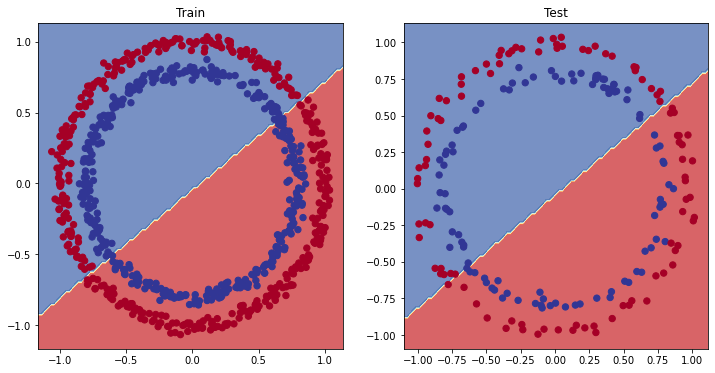

In [30]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)